In [1]:
import sys

import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

sys.path.append('..')

from seismicpro.batchflow import Dataset
from seismicpro.src import SeismicBatch, FieldIndex, seismic_plot


In [2]:
def get_avg_spectrogram(smg, traces_frame, time_frame_width=100, noverlap=None, do_time_avg=True):
    x = smg[traces_frame]
    f, t, Sxx = signal.spectrogram(x, window=('tukey', 0.25), nperseg=time_frame_width, noverlap=noverlap)
    avg_spec = Sxx.mean(axis=0)
    if do_time_avg:
        avg_spec = avg_spec.mean(axis=-1)
    return avg_spec

def get_spectrogram_dist_heatmap(smgr, smgl, n_trace_frames, time_frame_width=100, noverlap=None, mode='max_abs'):
    results = None
    traces_frame_width = smgr.shape[0] // n_trace_frames
    for tf in range(n_trace_frames):
        frame_begin = traces_frame_width * tf
        traces_frame = slice(frame_begin, frame_begin + traces_frame_width)

        kwargs = dict(time_frame_width=time_frame_width, do_time_avg=False, noverlap=noverlap)
        sl = get_avg_spectrogram(smgl, traces_frame, **kwargs)
        sr = get_avg_spectrogram(smgr, traces_frame, **kwargs)

        if callable(mode):  # res(sl, sr)
            res = mode(sl, sr)
        elif mode == 'max_abs':
            res = np.abs(sl - sr).max(axis=0)
        elif mode == 'sum_abs':
            res = np.sum(np.abs(sl - sr), axis=0)
        elif mode == 'sum_sq':
            res = np.sum(np.abs(sl - sr) ** 2, axis=0)
        else:
            raise NotImplemented('modes other than max_abs, sum_abs, sum_sq not implemented yet')

        if results is None:
            results = res
        else:
            results = np.vstack((results, res))
    return results

def draw_heatmaps(smgrs, smgls, n_trace_frames, time_frame_width=100, noverlap=None,
                  mode='max_abs', cv_res=None, figsize=(15, 15)):
    cv_smg = np.abs(np.quantile(np.stack(smgrs), 0.1))

    fig, axs = plt.subplots(len(smgrs), 3, figsize=figsize)

    for smgr, smgl in zip(smgrs, smgls):
        results = get_stft_dist_heatmap(smgr, smgl, n_trace_frames, time_frame_width, noverlap, mode)

        axs[field, 0].imshow(smgr.T, vmin=-cv_smg, vmax=cv_smg, cmap='gray', aspect='auto')
        axs[field, 1].imshow(smgl.T, vmin=-cv_smg, vmax=cv_smg, cmap='gray', aspect='auto')
        axs[field, 2].imshow(results.T, vmin=0, vmax=cv_res, cmap='gray', aspect='auto')

In [22]:
def draw_modifications(modifications, vmin=None, vmax=None, figsize=(15, 15), time_frame_width=100, noverlap=None, mode='max_abs'):
    fig, axs = plt.subplots(1, len(modifications), figsize=figsize)    
    origin, _ = modifications[0]
    frame = slice(0, origin.shape[0]//10)
#     print(origin[frame].shape)
    
    for i, (mod, description) in enumerate(modifications):
        dist_v = get_spectrogram_dist_heatmap(mod[frame], origin[frame], n_trace_frames=1, time_frame_width=time_frame_width, noverlap=noverlap, mode=mode)
        dist = np.mean(dist_v)

        axs[i].imshow(mod.T, vmin=vmin, vmax=vmax, cmap='gray')
        axs[i].set_title("{},\ndist from original is: {:.4}".format(description, dist))

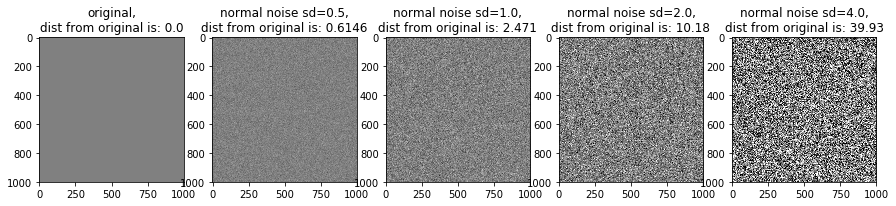

In [6]:
origin_shape = (1000, 1000)
origin = np.zeros(shape=origin_shape)
modifications = [(origin, "original")]
for i in range(1,5):
    mod = origin + np.random.normal(scale=2**i/4, size=origin_shape)
    modifications.append((mod, "normal noise sd={}".format(2**i/4)))
                         
draw_modifications(modifications, vmin=-6, vmax=6)    

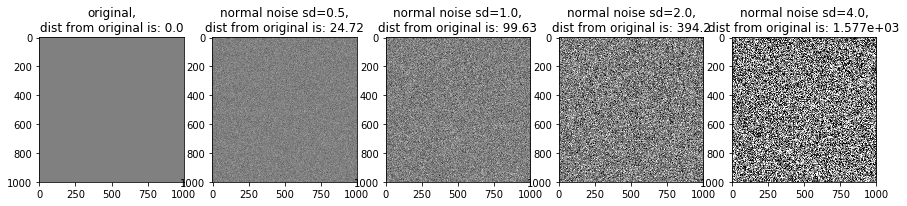

In [7]:
draw_modifications(modifications, vmin=-6, vmax=6, mode='sum_abs')    

In [8]:
raw = np.load('raw_1.npy')
lift = np.load('lift_1.npy')
out = np.load('out_1.npy')
att = np.load('att_1.npy')

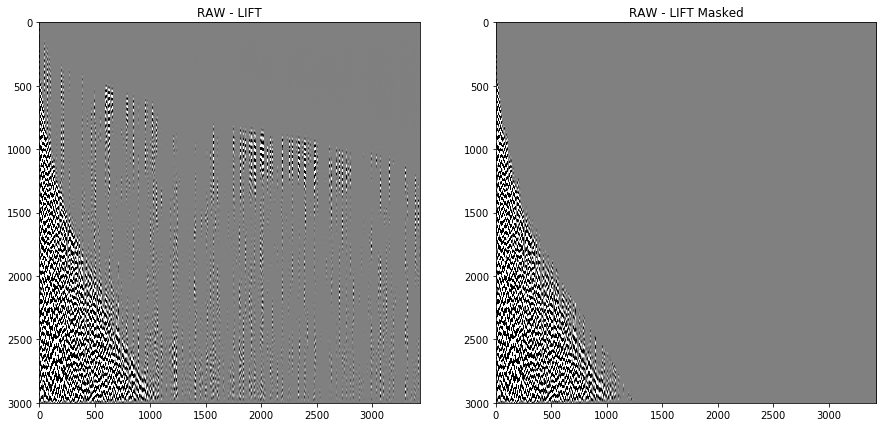

In [9]:
diff = raw - lift
diff_m = diff * (1 - att)

cv = 0.1
seismic_plot([diff, diff_m], figsize=(15, 7), names=['RAW - LIFT', 'RAW - LIFT Masked'],
             cmap='gray', vmin=-cv, vmax=cv)

In [10]:
modifications = [(lift, "lifted")]

for i in range(4):
    scale = 2**i/8
    mod = lift + diff_m * scale
    modifications.append((mod, "noise diff scale={}".format(scale)))
    
modifications.append((raw, "raw"))
modifications.append((out, "output"))

In [11]:
def get_cv(arrs, q=0.95):
    return np.abs(np.quantile(np.stack(item for item in arrs), q))

In [12]:
cv = get_cv([raw])

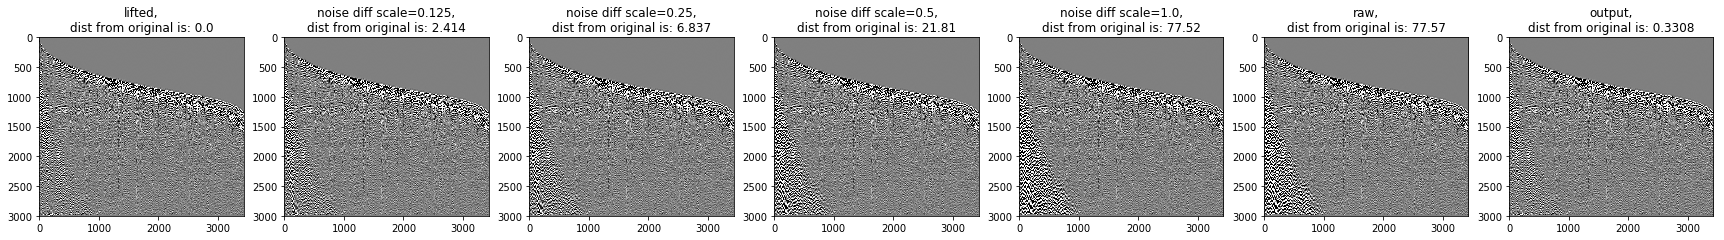

In [13]:
draw_modifications(modifications, vmin=-cv, vmax=cv, mode='max_abs', figsize=(30, 10))    

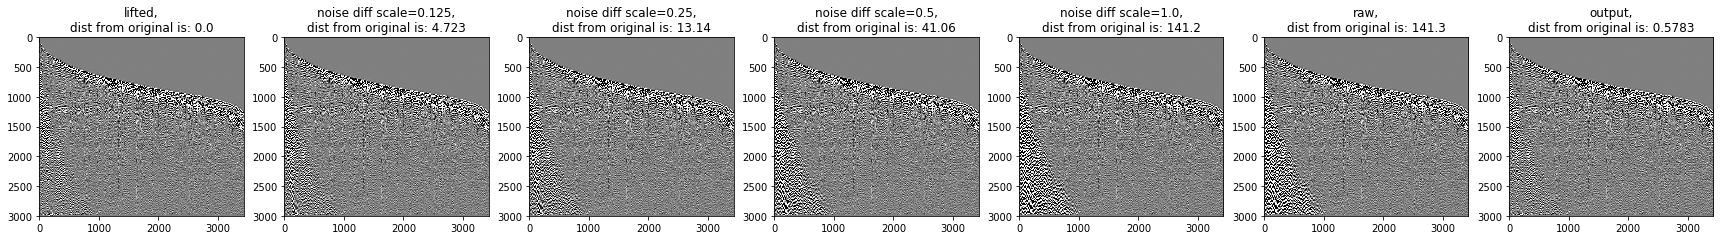

In [14]:
draw_modifications(modifications, vmin=-cv, vmax=cv, mode='sum_abs', figsize=(30, 10))    

(343, 3000)


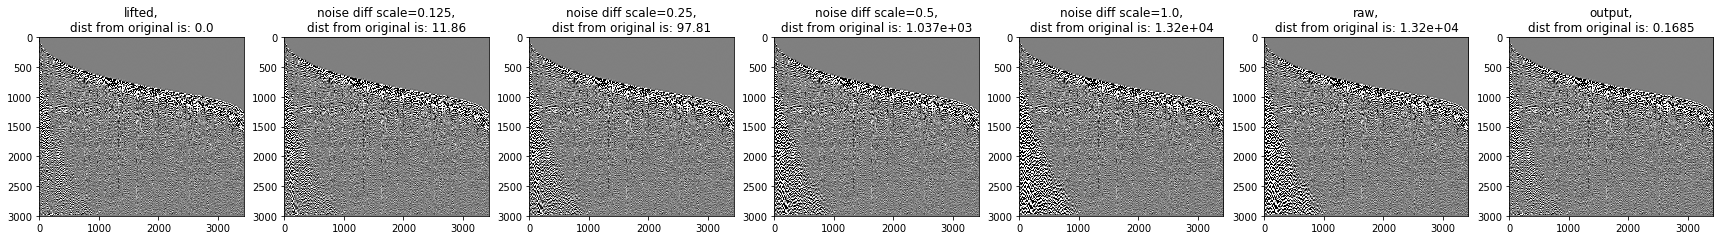

In [19]:
draw_modifications(modifications, vmin=-cv, vmax=cv, mode='sum_sq', figsize=(30, 10))  

In [20]:
modifications = [(lift, "lifted")]

for i in range(4):
    scale = 2**i/8
    mod = lift + np.random.normal(scale=scale, size=raw.shape) * (1 - att)
    modifications.append((mod, "normal noise scale={}".format(scale)))
    
modifications.append((raw, "raw"))
modifications.append((out, "output"))

(343, 3000)


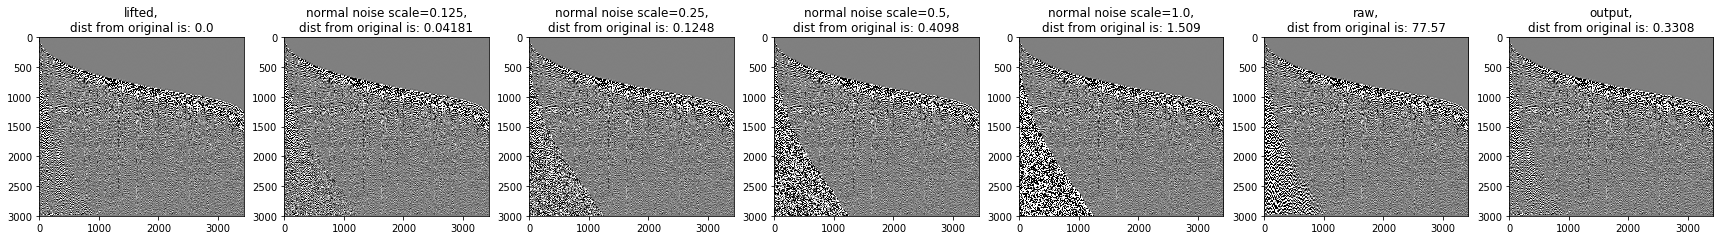

In [21]:
draw_modifications(modifications, vmin=-cv, vmax=cv, mode='max_abs', figsize=(30, 10))    

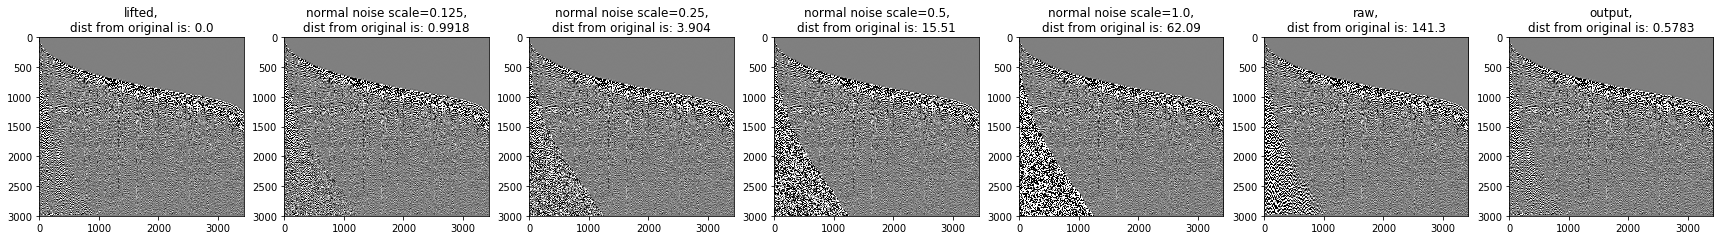

In [23]:
draw_modifications(modifications, vmin=-cv, vmax=cv, mode='sum_abs', figsize=(30, 10))    

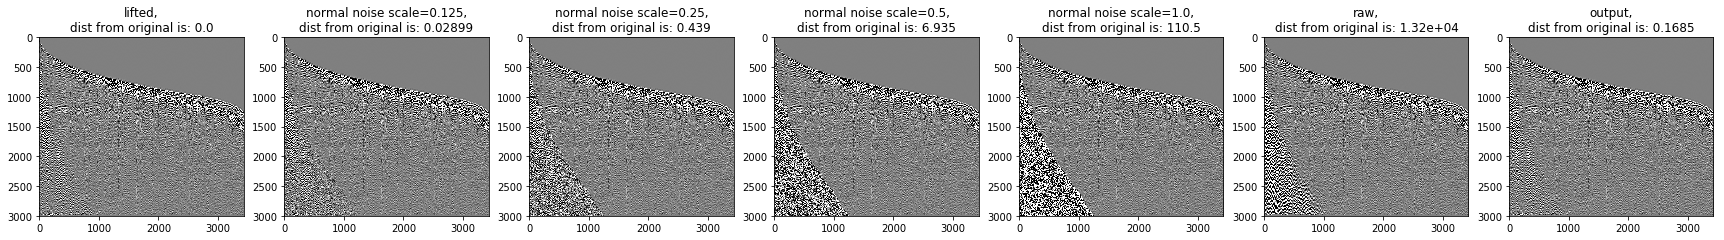

In [24]:
draw_modifications(modifications, vmin=-cv, vmax=cv, mode='sum_sq', figsize=(30, 10))    

In [70]:
def get_spectrogram_dist_heatmap_2(smgr, smgl, n_trace_frames, time_frame_width=100, noverlap=None, mode='max_abs'):
    results = None
    traces_frame_width = smgr.shape[0] // n_trace_frames
    for tf in range(n_trace_frames):
        frame_begin = traces_frame_width * tf
        traces_frame = slice(frame_begin, frame_begin + traces_frame_width)
        
        kwargs = dict(window=('tukey', 0.25), nperseg=time_frame_width, noverlap=noverlap)
        f, t, Sxx_l = signal.spectrogram(smgl[traces_frame], **kwargs)
        f, t, Sxx_r = signal.spectrogram(smgr[traces_frame], **kwargs)
        
        if callable(mode):  # res(sl, sr)
            res = mode(Sxx_l, Sxx_r)
        elif mode == 'max_abs':
            res = np.abs(Sxx_l - Sxx_r).max(axis=1)
        elif mode == 'sum_abs':
            res = np.sum(np.abs(Sxx_l - Sxx_r), axis=1)
        elif mode == 'sum_sq':
            res = np.sum(np.abs(Sxx_l - Sxx_r) ** 2, axis=1)
#         elif mode == 'corr'
        else:
            raise NotImplemented('modes other than max_abs, sum_abs, sum_sq not implemented yet')
            
        print(res.shape)
        res = np.mean(res, axis=0)

        if results is None:
            results = res
        else:
            results = np.vstack((results, res))
    return results

def draw_modifications_2(modifications, vmin=None, vmax=None, figsize=(15, 15), time_frame_width=100, noverlap=None, mode='max_abs',frame=None):
    fig, axs = plt.subplots(1, len(modifications), figsize=figsize)    
    origin, _ = modifications[0]
    if frame is None:
        frame = slice(0, origin.shape[0]//10)
#     print(origin[frame].shape)
    
    for i, (mod, description) in enumerate(modifications):
        dist_v = get_spectrogram_dist_heatmap_2(mod[frame], origin[frame], n_trace_frames=1, time_frame_width=time_frame_width, noverlap=noverlap, mode=mode)
        dist = np.mean(dist_v)

        axs[i].imshow(mod.T, vmin=vmin, vmax=vmax, cmap='gray')
        axs[i].set_title("{},\ndist from original is: {:.4}".format(description, dist))

In [29]:
modifications = [(lift, "lifted")]

for i in range(4):
    scale = 2**i/8
    mod = lift + diff_m * scale
    modifications.append((mod, "noise diff scale={}".format(scale)))
    
modifications.append((raw, "raw"))
modifications.append((out, "output"))

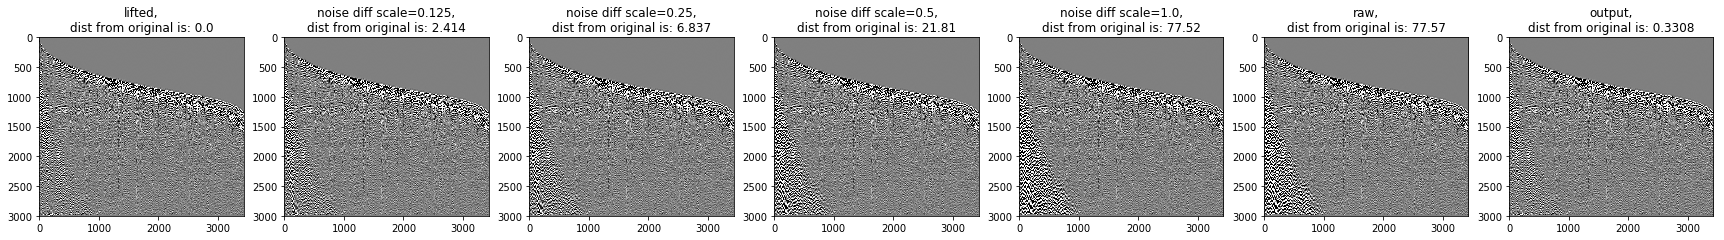

In [30]:
draw_modifications(modifications, vmin=-cv, vmax=cv, mode='max_abs', figsize=(30, 10))    

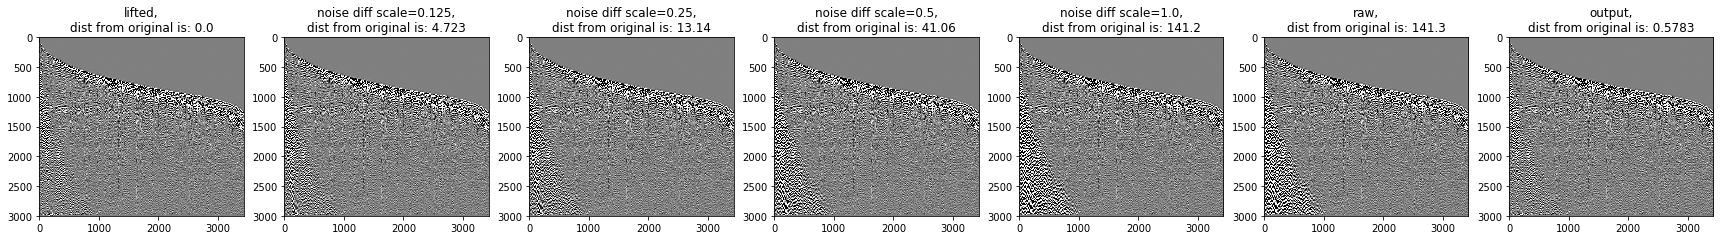

In [31]:
draw_modifications(modifications, vmin=-cv, vmax=cv, mode='sum_abs', figsize=(30, 10))    

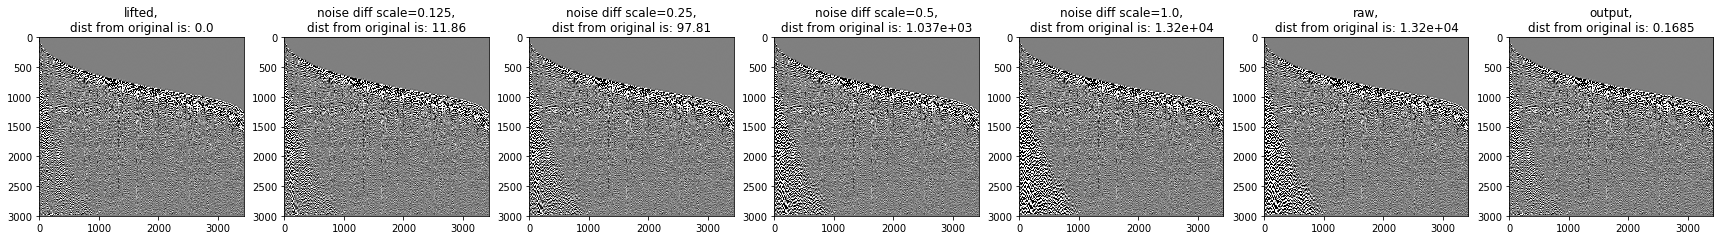

In [32]:
draw_modifications(modifications, vmin=-cv, vmax=cv, mode='sum_sq', figsize=(30, 10))  

In [33]:
modifications = [(lift, "lifted")]

for i in range(4):
    scale = 2**i/8
    mod = lift + np.random.normal(scale=scale, size=raw.shape) * (1 - att)
    modifications.append((mod, "normal noise scale={}".format(scale)))
    
modifications.append((raw, "raw"))
modifications.append((out, "output"))

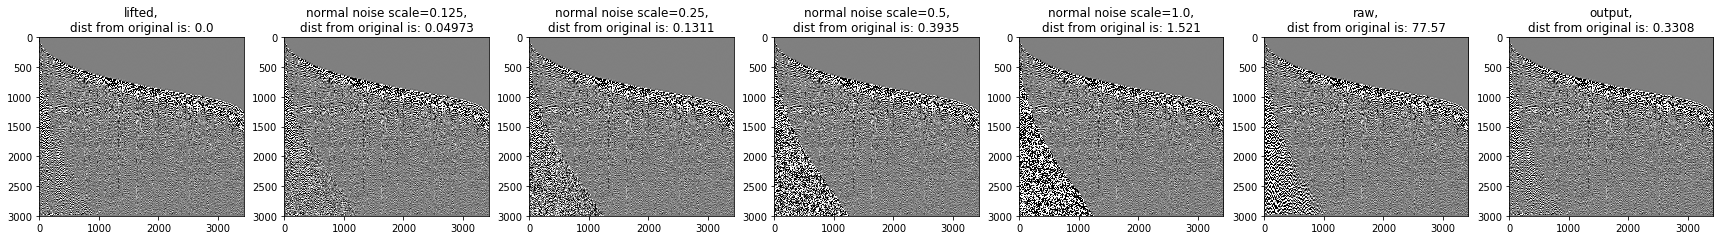

In [34]:
draw_modifications(modifications, vmin=-cv, vmax=cv, mode='max_abs', figsize=(30, 10))    

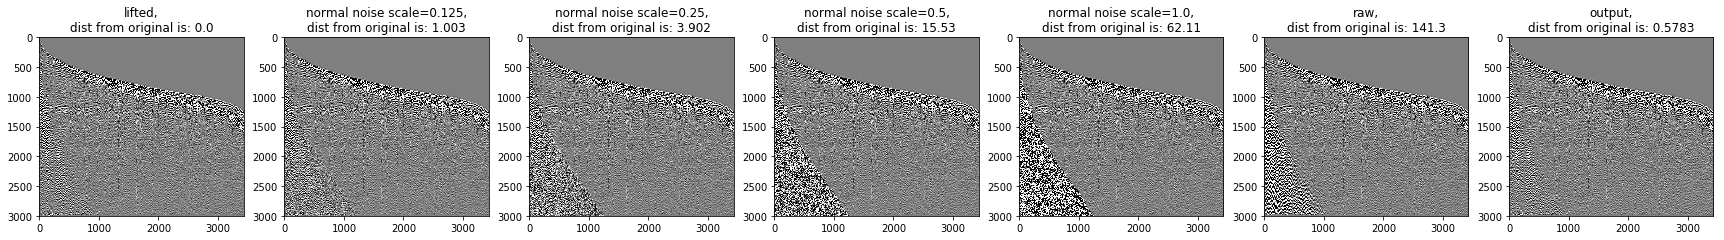

In [35]:
draw_modifications(modifications, vmin=-cv, vmax=cv, mode='sum_abs', figsize=(30, 10))    

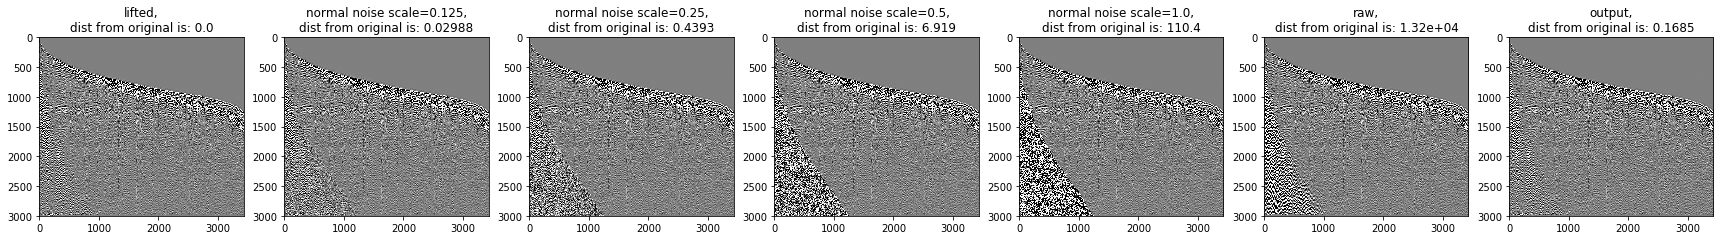

In [36]:
draw_modifications(modifications, vmin=-cv, vmax=cv, mode='sum_sq', figsize=(30, 10))    

In [75]:
# from scipy.spatial import distance
from scipy.linalg import norm

a = np.stack(K * np.ones(shape=(2,3)) for K in range(1,5))
def get_corr_dist_map(u, v):
    umu = np.mean(u, axis=1, keepdims=True)
#     print('------------ umu ------------')
#     print(umu)
    vmu = np.mean(v, axis=1, keepdims=True)
#     print('------------ vmu ------------')
#     print(vmu)
    um = u - umu
    print('------------ u - umu ------------')
    print(um)
    vm = v - vmu
    print('------------ v - vmu ------------')
    print(vm)
     
    print('------------ um*vm ------------')
    print(um*vm)
    
    dot = np.sqrt(np.sum(um*vm, axis=1, keepdims=True))    
    
    return 1.0 - dot / (norm(um, axis=1, keepdims=True) * norm(vm, axis=1, keepdims=True))


------------ u - umu ------------
[[[-4.53181982e+00]
  [ 2.40697422e+01]
  [-4.38351059e+00]
  [-5.00029898e+00]
  [-5.02596760e+00]
  [-5.12814569e+00]]

 [[-9.72961485e-01]
  [ 5.26169300e+00]
  [-6.25550807e-01]
  [-1.19794071e+00]
  [-1.16168523e+00]
  [-1.30355430e+00]]

 [[-4.96470835e-04]
  [-3.65300511e-04]
  [ 1.26329216e-03]
  [ 5.17784967e-04]
  [-4.21577541e-04]
  [-4.97728237e-04]]

 [[-6.39338326e-03]
  [-4.46474785e-03]
  [ 8.14684480e-03]
  [ 1.35877281e-02]
  [-4.62634116e-03]
  [-6.25009881e-03]]

 [[-4.60658688e-04]
  [-4.68656712e-04]
  [ 5.35169209e-04]
  [ 1.18815876e-03]
  [-3.26232897e-04]
  [-4.67779697e-04]]

 [[-1.19261211e-04]
  [ 1.62291282e-04]
  [ 1.81254407e-04]
  [ 6.20500214e-06]
  [-1.09413268e-04]
  [-1.21076337e-04]]

 [[-1.73812459e-05]
  [ 5.63038484e-05]
  [ 4.22478661e-06]
  [-1.01381311e-05]
  [-1.59200499e-05]
  [-1.70892017e-05]]

 [[-3.73489115e-06]
  [ 1.32055375e-05]
  [-1.88732724e-06]
  [ 1.21752328e-06]
  [-4.11899146e-06]
  [-4.681851

TypeError: 'AxesSubplot' object does not support indexing

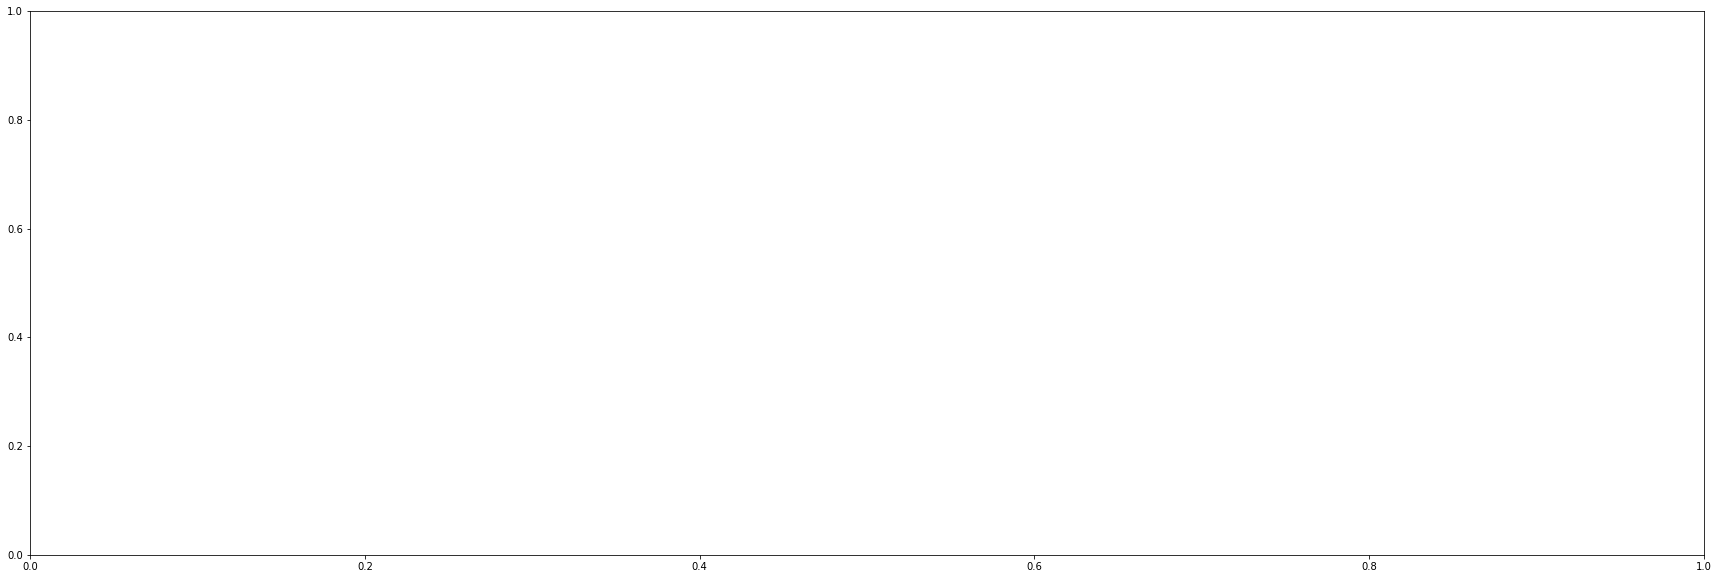

In [77]:
draw_modifications_2(modifications[0:1], vmin=-cv, vmax=cv, mode=get_corr_dist_map, figsize=(30, 10), frame=(slice(0, 10), slice(0, 10)))

In [37]:
a = np.stack(K * np.ones(shape=(2,3)) for K in range(1,5))
a

array([[[1., 1., 1.],
        [1., 1., 1.]],

       [[2., 2., 2.],
        [2., 2., 2.]],

       [[3., 3., 3.],
        [3., 3., 3.]],

       [[4., 4., 4.],
        [4., 4., 4.]]])

In [52]:
ma = np.mean(a, axis=1, keepdims=True)
ma.shape

(4, 1, 3)

In [53]:
ma

array([[[1., 1., 1.]],

       [[2., 2., 2.]],

       [[3., 3., 3.]],

       [[4., 4., 4.]]])

In [54]:
a - ma

array([[[0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.]]])

In [44]:
from scipy.linalg import norm
norm(a, axis=1)

array([[1.41421356, 1.41421356, 1.41421356],
       [2.82842712, 2.82842712, 2.82842712],
       [4.24264069, 4.24264069, 4.24264069],
       [5.65685425, 5.65685425, 5.65685425]])

In [42]:
[i*np.sqrt(2) for i in range(1,5)]

[1.4142135623730951, 2.8284271247461903, 4.242640687119286, 5.656854249492381]

In [45]:
norm(a, axis=2)

array([[1.73205081, 1.73205081],
       [3.46410162, 3.46410162],
       [5.19615242, 5.19615242],
       [6.92820323, 6.92820323]])

In [46]:
[i*np.sqrt(3) for i in range(1,5)]

[1.7320508075688772, 3.4641016151377544, 5.196152422706632, 6.928203230275509]

In [48]:
norm(a, axis=0)

array([[5.47722558, 5.47722558, 5.47722558],
       [5.47722558, 5.47722558, 5.47722558]])

In [49]:
norm([1,2,3,4])

5.477225575051661